# K9 (uniCHM ov IAPEzint)

In [1]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
def get_bigwig_mean(bw_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


def scan_bw_signal_split2bins(bw_scan, name, capture_regions_file, bigwig_files, labels, resolution=100, left_span=2000, right_span=2000, origin_len = 1) :
    cmd = f'''awk '{{print $1"\\t"$2-{left_span}-{resolution >> 1}"\\t"$3+{right_span}+{resolution >> 1}"\\t"$4"\\t"$5"\\t"$6}}' {capture_regions_file} > capture_regions.bed '''
    print(subprocess.check_output(cmd, shell=True).decode(), end='')
    
    capture_points = int((left_span + right_span) / resolution + 1) if (left_span+right_span) > 0 else int(origin_len / resolution + 1)
    capture_regions_file = 'capture_regions.bed'
    bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s {capture_points} -m speed -b {capture_regions_file}'

    for bigwig_file in bigwig_files:
        bw_scan_cmd += f' -w {bigwig_file}'
    
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

    xticks = np.arange(-left_span, right_span + resolution, resolution) if (left_span+right_span) > 0 else np.arange(0, origin_len + resolution, resolution)
    signal = {}
    for index, (bigwig_file, label) in enumerate(zip(bigwig_files, labels)):
        mean = get_bigwig_mean(bigwig_file)
        signal[label] = pd.read_csv(f'signal_{name}_siteprof{index+1}.gz',
                                    sep='\t',
                                    header=None,
                                    index_col=None,
                                    names=xticks) / mean     
    return signal

In [3]:
stage_dict = {
    'EarlyEmbryogenesis': ['2cell','8cell','Morula','ICM',],
    'PGCsDevelopment': ['E10.5','E13.5_female','E13.5_male',],
    'Spermatogenesis': ['US','DS','PS','RS',],
    'RetinalDevelopment': ['E14.5','E17.5','P0','P3','P7','P10','P14','P21',],
    'HeartDevelopment': ['E10.5','E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0',],
    'LiverDevelopment': ['E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0']
}

In [18]:
%%bash
### 5end 3end
cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/overlap_IAPEz
for bed in IAPEz_specific.bed IAPEz_universalCHM_overlap.bed universalCHM_IAPEz_overlap.bed universalCHM_specific.bed;do
    name=${bed%%.bed}
    awk 'BEGIN{FS=OFS="\t"}{print $1, $2-1, $2}' $bed > ${name}.5end.bed
    awk 'BEGIN{FS=OFS="\t"}{print $1, $3, $3+1}' $bed > ${name}.3end.bed
done

In [20]:
%%bash
cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/overlap_IAPEz/K9/
# ln -s ../*.bed .
wc -l *.bed


   705 capture_regions.bed
  1121 IAPEz_specific.3end.bed
  1121 IAPEz_specific.5end.bed
  1121 IAPEz_specific.bed
  2625 IAPEz_universalCHM_overlap.3end.bed
  2625 IAPEz_universalCHM_overlap.5end.bed
  2625 IAPEz_universalCHM_overlap.bed
  1972 universalCHM_IAPEz_overlap.3end.bed
  1972 universalCHM_IAPEz_overlap.5end.bed
  1972 universalCHM_IAPEz_overlap.bed
   705 universalCHM_specific.3end.bed
   705 universalCHM_specific.5end.bed
   705 universalCHM_specific.bed
 19974 total


In [23]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/overlap_IAPEz/K9')
signal_AB_dict = {}
for end in ['5end', '3end', 'body'] :
    signal_AB_dict[end] = {}
    for t in ['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific'] :
        bed_fi = f'{t}.{end}.bed' if end != 'body' else f'{t}.bed'
        bw_scan = True if end != 'body' else False
        left_span = 0 if end != '5end' else 100000
        right_span = 0 if end != '3end' else 100000
        origin_len = 0 if end != 'body' else 5000 # average Universal CHM length
        signal_AB_dict[end][t] = scan_bw_signal_split2bins(
            bw_scan = bw_scan,
            name = f'K9_around_{t}_{end}',
            capture_regions_file = bed_fi,
            resolution = 100,
            left_span = left_span,
            right_span = right_span,
            origin_len = origin_len,
            bigwig_files = [f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/MethK9Signal/{process}_{stage}.H3K9me3.rmDup.bw' for process in stage_dict.keys() for stage in stage_dict[process]],
            labels = [f'{process}_{stage}_H3K9me3' for process in stage_dict.keys() for stage in stage_dict[process]],
        )

In [24]:
signal_AB_concat_dict = {}
for span in [50000] :
    signal_AB_concat_dict[span] = {}
    for t in ['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific'] :
        signal_AB_concat_dict[span][t] = {}
        for i,label in enumerate([f'{process}_{stage}_H3K9me3' for process in stage_dict.keys() for stage in stage_dict[process]]) :        
            signal_AB_concat_dict[span][t][label] = pd.concat([signal_AB_dict['5end'][t][label][np.arange(-span, 0, 100)], 
                                                               signal_AB_dict['body'][t][label], 
                                                               signal_AB_dict['3end'][t][label][np.arange(100, span+100, 100)]], axis = 1)
            body_len = signal_AB_dict['body'][t][label].columns[-1] - signal_AB_dict['body'][t][label].columns[0]
            signal_AB_concat_dict[span][t][label].columns = np.arange(-span, 0, 100).tolist() + signal_AB_dict['body'][t][label].columns.tolist() + (np.arange(100, span+100, 100) + body_len).tolist() 
                
signal_AB_concat_dict[span][t][label]

,-50000,-49900,-49800,-49700,-49600,-49500,-49400,-49300,-49200,-49100,...,54100,54200,54300,54400,54500,54600,54700,54800,54900,55000
0,0.711313,0.785249,0.787799,0.762304,0.735534,0.921648,0.754655,0.730435,0.789074,0.490781,...,0.536672,0.597860,0.743182,1.151115,1.570627,1.444424,1.004507,1.024903,0.986661,1.009606
1,1.133257,0.831140,0.926747,1.415059,1.800083,1.740175,1.425262,1.696817,1.860005,1.792437,...,1.487755,1.551506,1.313064,1.321972,1.690457,1.440581,1.819204,1.559111,1.320688,2.116228
2,1.536201,1.744004,1.381931,0.772502,0.963715,1.573185,1.676437,1.304151,1.724883,1.692974,...,1.065706,0.926747,1.162577,0.884680,0.567266,0.826041,1.074619,1.221262,0.822217,0.152971
3,1.134532,1.154952,1.551492,1.714680,1.384462,1.603781,1.511951,0.836239,1.499190,1.727414,...,0.741908,0.559618,0.696016,0.773776,0.444890,0.780150,1.606312,1.800083,1.712136,1.167704
4,0.899980,1.330915,1.216139,1.031289,1.372986,1.358967,1.281159,1.225076,1.744004,1.416344,...,1.778418,2.595533,2.371179,1.992582,2.100936,2.185067,2.196543,2.100936,2.576412,3.357842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,0.202686,0.883405,1.364095,1.738903,2.433644,1.684070,1.140906,1.286252,1.037651,0.928022,...,1.249279,1.081015,1.267163,1.579558,1.362796,1.128165,0.869383,0.884680,1.350035,1.672607
701,0.933121,1.663676,2.100936,2.055034,1.624135,0.968814,0.896153,1.214890,1.357681,1.313039,...,0.716412,0.919099,1.227607,1.200842,0.660323,0.597860,1.315596,1.617801,1.158775,1.044025
702,0.729160,1.228919,1.703204,1.689185,1.515794,0.986681,1.003232,1.506863,1.834509,1.819204,...,0.284270,0.651400,0.544321,0.356931,0.393899,0.342909,0.260050,0.409196,0.484407,0.813294
703,1.244172,1.330901,1.574457,1.798811,1.783519,1.603781,1.620332,1.899519,2.489736,3.041697,...,2.065237,2.325290,2.566222,2.255179,2.164674,2.244975,2.409421,2.493553,2.984333,2.651625


In [48]:
colors = ['#4297A0', '#2F5061', '#E57F84', '#D4CAC6',]

In [27]:
signal_AB_concat_dict[span][t][label][-50000].dropna().mean()

1.462157651917314

In [28]:
stage_3_dict = {
 'EarlyEmbryogenesis': ['2cell', '8cell', 'ICM'],
 'PGCsDevelopment': ['E10.5', 'E13.5_female', 'E13.5_male'],
 'Spermatogenesis': ['US', 'DS', 'RS'],
 'RetinalDevelopment': ['E14.5', 'P0', 'P21'],
 'HeartDevelopment': ['E10.5', 'E13.5', 'P0'],
 'LiverDevelopment': ['E11.5', 'E14.5', 'P0']
}

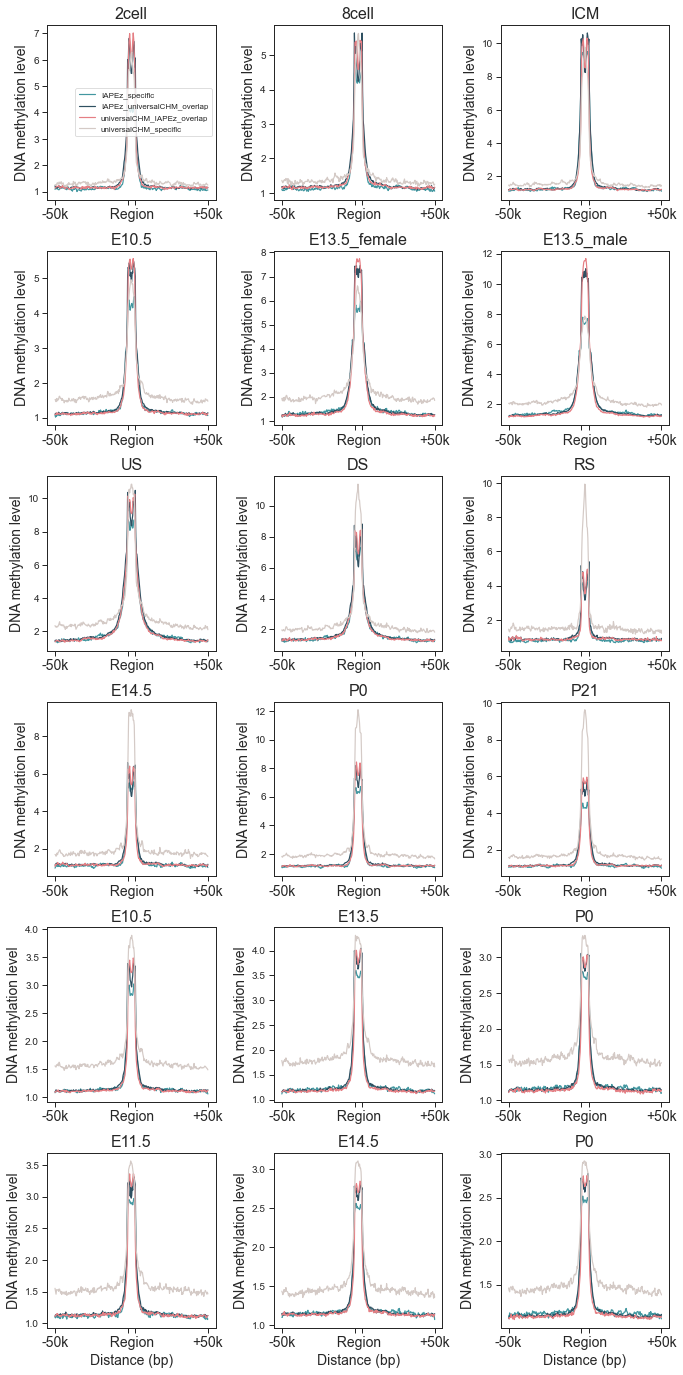

In [49]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 16,
                             'axes.labelsize': 14,
                             'xtick.labelsize': 14,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    
    for span in [50000] :    
        fig, axes = plt.subplots(6, 3, figsize=(6.4 * 1.5, 4.8 * 4), sharey = False, sharex = False, tight_layout = True)  
        for a,process in enumerate(stage_dict.keys()) :
            for b,stage in enumerate(stage_3_dict[process]) : 
                ax = axes[a, b]
                label = f'{process}_{stage}_H3K9me3'
                for j,t in enumerate(['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific']) :
                    x = signal_AB_concat_dict[span][t][label].columns
                    xnew = np.linspace(x.min(), x.max(), 300) 
                    spl = make_interp_spline(x, signal_AB_concat_dict[span][t][label].mean(), k = 1)
                    signal_smooth = spl(xnew)
                    ax.plot(xnew, signal_smooth, label=t, color=colors[j])

                h, l = ax.get_legend_handles_labels()
                if a == 0 and b == 0 :
                    ax.legend(h, ['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific'], title='')

                ax.set_xticks([-span, 0, 5000, 5000+span])
                ax.set_xticklabels([f'-{str(span)[:-3]}k', "  Region", "", f"+{str(span)[:-3]}k"])

                if a == (len(stage_dict.keys()) - 1) :
                    ax.set_xlabel('Distance (bp)')
                ax.set_ylabel('DNA methylation level')
                ax.set_title(f'{stage}')

#                 ax.set_ylim(0,1)

#         fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_DNAmeth_3stages_UniversalCHM_overlap_ABcompart_{cell_type}_{str(span)[:-3]}k_5tissue.pdf', transparent=True)        


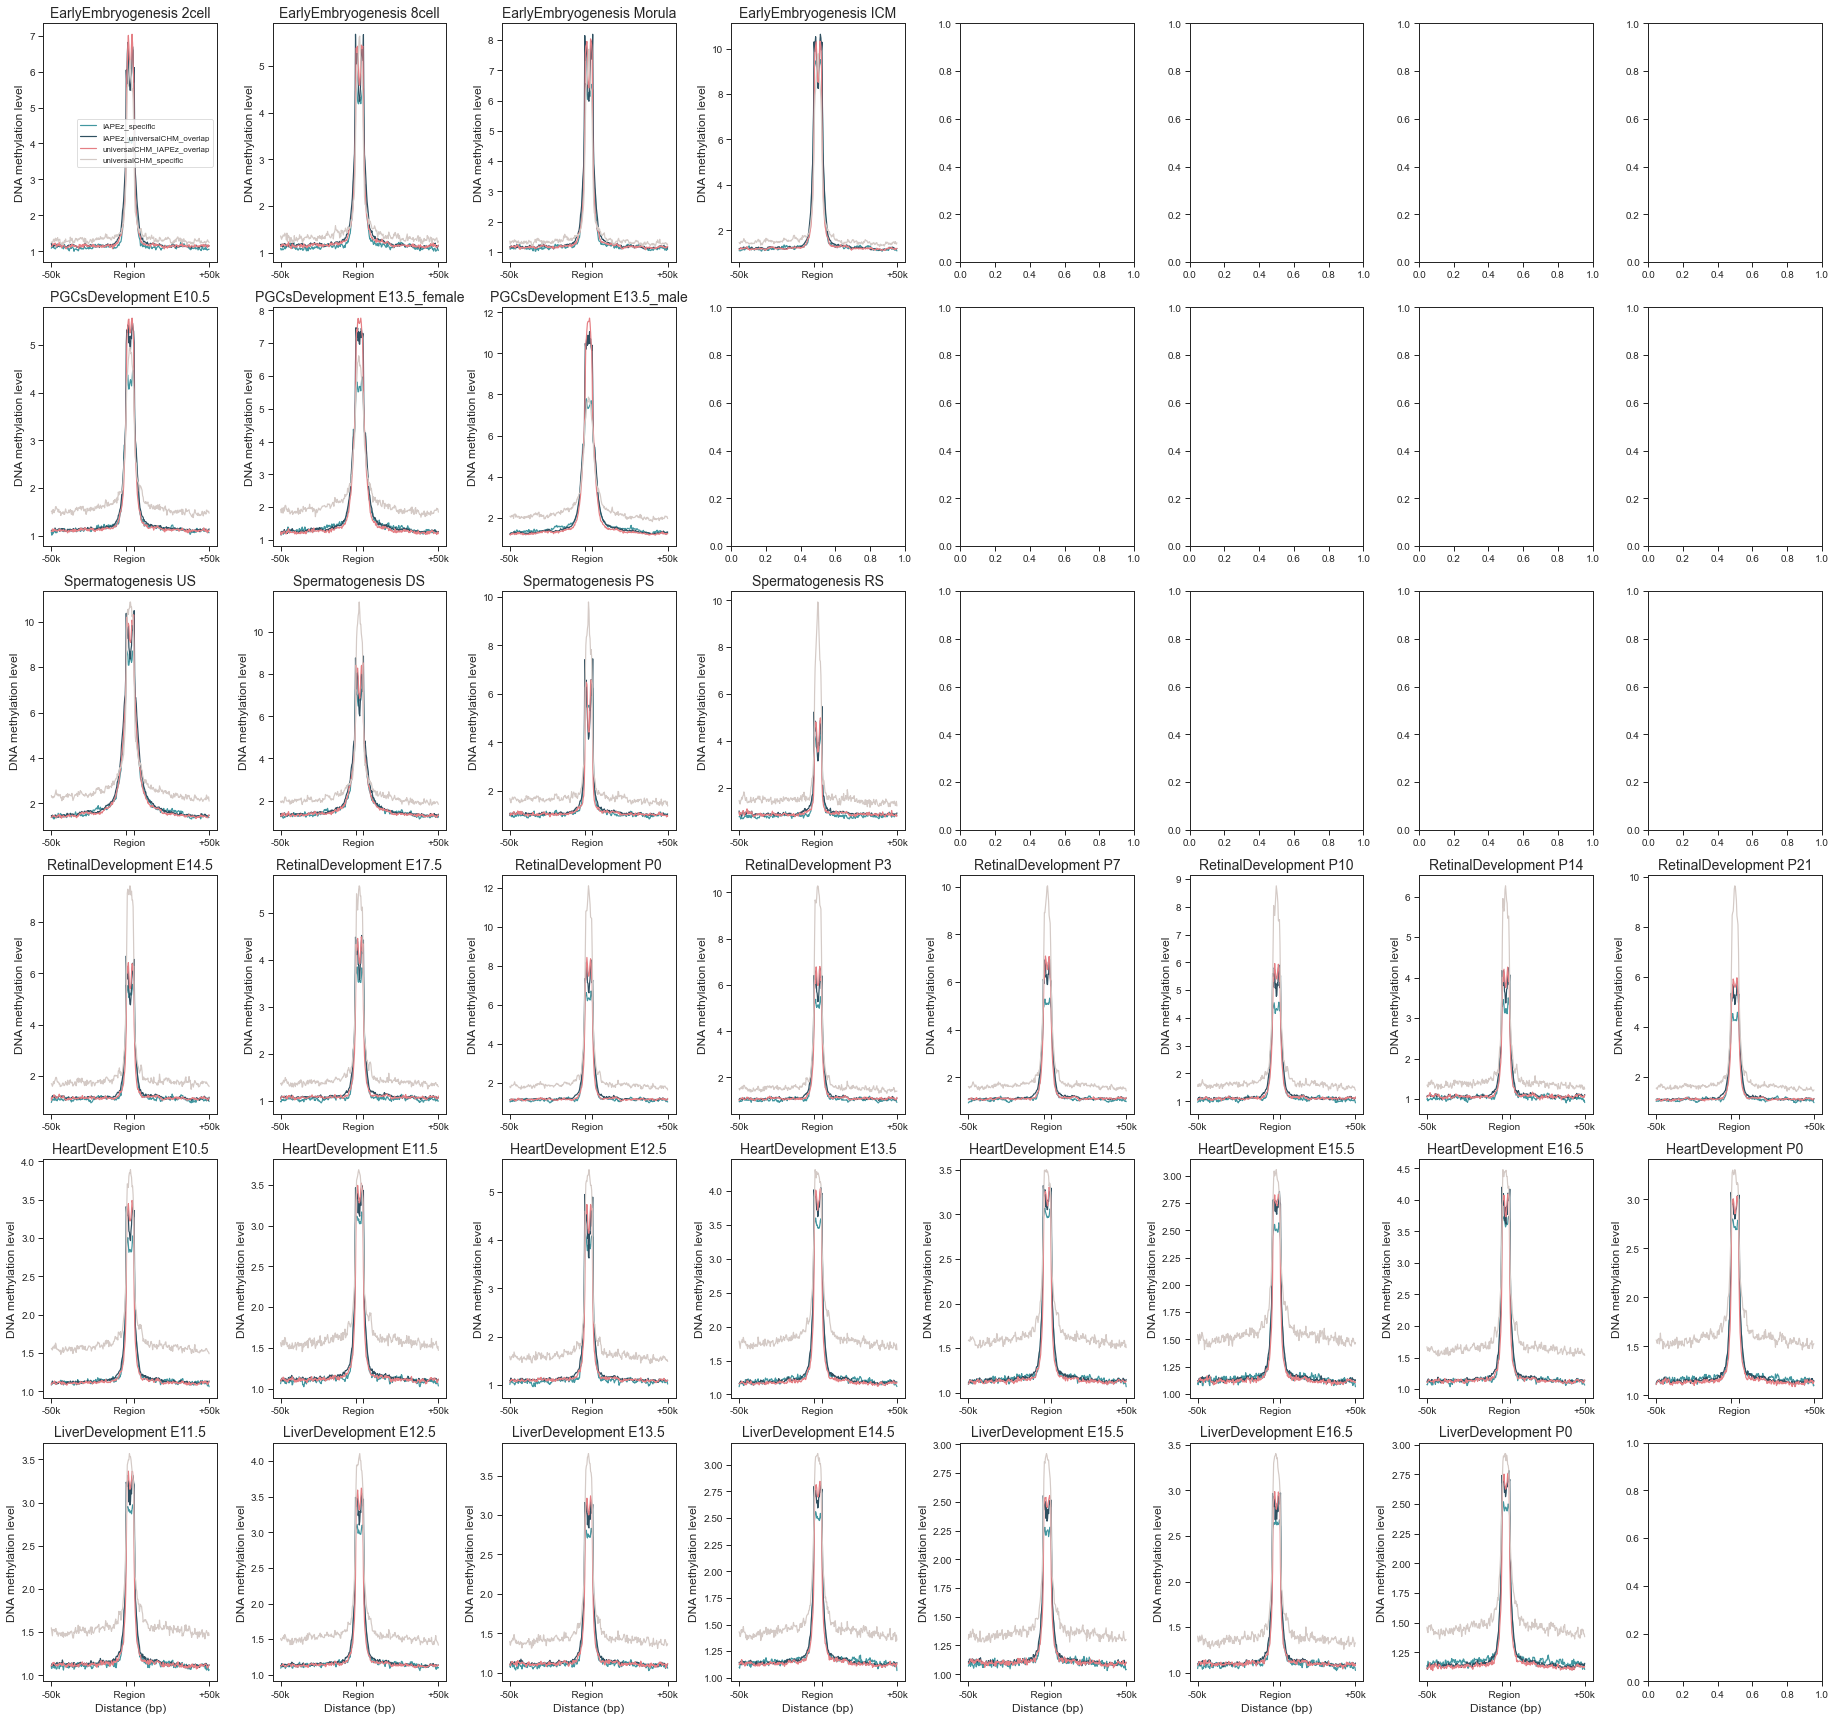

In [51]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    
    for span in [50000] :    
        fig, axes = plt.subplots(6, 8, figsize=(6.4 * 4, 4.8 * 5), sharey = False, sharex = False, tight_layout = True)  
        for a,process in enumerate(stage_dict.keys()) :
            for b,stage in enumerate(stage_dict[process]) : 
                ax = axes[a, b]
                label = f'{process}_{stage}_H3K9me3'
                for j,t in enumerate(['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific']) :
                    x = signal_AB_concat_dict[span][t][label].columns
                    xnew = np.linspace(x.min(), x.max(), 300) 
                    spl = make_interp_spline(x, signal_AB_concat_dict[span][t][label].mean(), k = 3)
                    signal_smooth = spl(xnew)
                    ax.plot(xnew, signal_smooth, label=t, color=colors[j])
                    
                h, l = ax.get_legend_handles_labels()
                if a == 0 and b == 0 :
                    ax.legend(h, ['IAPEz_specific', 'IAPEz_universalCHM_overlap', 'universalCHM_IAPEz_overlap', 'universalCHM_specific'], title='')

                ax.set_xticks([-span, 0, 5000, 5000+span])
                ax.set_xticklabels([f'-{str(span)[:-3]}k', "  Region", "", f"+{str(span)[:-3]}k"])

                if a == (len(stage_dict.keys()) - 1) :
                    ax.set_xlabel('Distance (bp)')
                ax.set_ylabel('DNA methylation level')
                ax.set_title(f'{process} {stage}')


        fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_H3K9me3_UniversalCHM_overlap_IAPEzint_{str(span)[:-3]}k_5tissue.pdf', transparent=True)        
